In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
code_root = project_root / "gbi_diff"
sys.path.extend([str(project_root), str(code_root)])
print(sys.path)

['/home/robin/miniconda3/envs/gbi/lib/python312.zip', '/home/robin/miniconda3/envs/gbi/lib/python3.12', '/home/robin/miniconda3/envs/gbi/lib/python3.12/lib-dynload', '', '/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages', '/home/robin/projects/lab_project/neuralgbi_diffusion', '/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_diff']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm

from gbi_diff.model.lit_module import (DiffusionModel, Guidance,
                                       PotentialNetwork)
from gbi_diff.sampling.utils import get_sample_path, load_observed_data
from gbi_diff.utils.criterion import SBICriterion
from gbi_diff.utils.plot import _pair_plot
from gbi_diff.utils.sampling_diffusion_config import Config
from gbi_diff.utils.train_diffusion_config import Config as DiffusionConfig
from gbi_diff.utils.train_guidance_config import Config as GuidanceConfig
from gbi_diff.sampling.diffusion import DiffusionSampler


In [3]:
guidance_ckpt = str(project_root) +  "/results/guidance/two_moons/lightning_logs/version_0/epoch=94-step=3800.ckpt"
# guidance_ckpt = str(project_root) +  "/results/guidance/two_moons/lightning_logs/version_6/epoch=59-step=2400.ckpt"
# guidance_ckpt = str(project_root) +  "/results/guidance/two_moons/lightning_logs/version_12/epoch=84-step=3400.ckpt"
guidance_model = Guidance.load_from_checkpoint(guidance_ckpt)
observed_data_file = project_root.joinpath("data","         .pt") 
x_o, thetas = load_observed_data(observed_data_file)
x_o = x_o.requires_grad_(True)
thetas = thetas.requires_grad_(True)

In [4]:
idx = 0
T = 0

Text(0.5, 0.98, 'Likelihood estimate vs gt: T=0, idx=0')

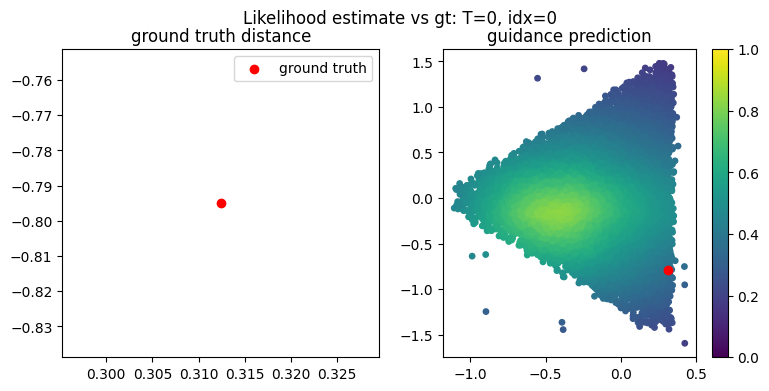

In [6]:
time_repr = guidance_model.get_diff_time_repr(np.ones(1) * T)
time_repr = time_repr.detach()
time_repr.requires_grad = True
theta = thetas[[idx]]
theta = theta.detach()
theta.requires_grad = True 

likelihood = guidance_model.forward(theta, x_o[None], time_repr)
grad = torch.autograd.grad(outputs=likelihood.sum(), inputs=x_o)[0]
# print(grad)
likelihood = np.exp(-likelihood[0, :, 0].detach().numpy())
criterion = SBICriterion()
ground_truth_distance = criterion.sample_distance(x_o[[idx]].detach(), x_o[None].detach())
gt_likelihood = np.exp(-ground_truth_distance[0])

fig, axs = plt.subplots(ncols=2, figsize=(9, 4))

# mapable =           
axs[0].scatter(*x_o[idx].detach(), c="r", label="ground truth")
axs[0].set_title("ground truth distance")
axs[0].legend()

mapable = axs[1].scatter(*x_o.detach().numpy().T, c=likelihood, s=15, label="observed data",  vmin=0, vmax=1)
axs[1].scatter(*x_o[idx].detach(), c="r", label="ground truth")
# axs[1].quiver(*x_o.T.detach().numpy(), *grad.T.detach().numpy(), scale=12)
axs[1].set_title("guidance prediction")


fig.colorbar(mapable)
fig.suptitle(f"Likelihood estimate vs gt: T={T}, idx={idx}")

Text(0.5, 1.0, 'L2 gradient norm')

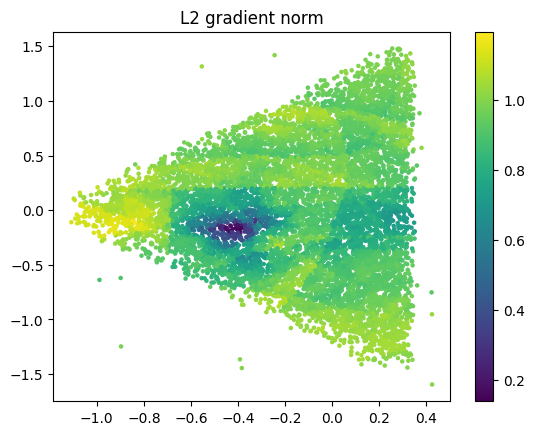

In [12]:
norms = torch.linalg.norm(grad, dim=-1)
plt.scatter(*x_o.detach().numpy().T, c=norms, s=5)
plt.colorbar()
plt.title("L2 gradient norm")

1000it [00:04, 207.68it/s]


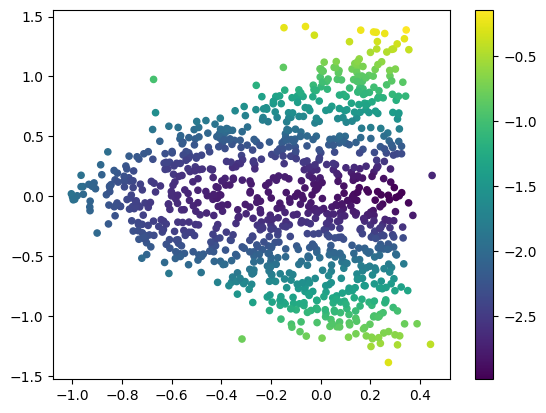

In [30]:
time_repr = guidance_model.get_diff_time_repr(np.ones(1) * T)
criterion = SBICriterion()
mean_dist = []
for x, theta in tqdm(zip(x_o, thetas)):
    likelihood = guidance_model.forward(theta[None], x_o[None], time_repr).detach().numpy()
    likelihood = likelihood[0, :, 0]
    # likelihood = np.exp(-likelihood[0, :, 0])
    gt_distance = criterion.sample_distance(x[None], x_o[None]).detach().numpy()
    gt_distance = gt_distance[0]
    # gt_likelihood = np.exp(-ground_truth_distance[0])
    # print(likelihood.shape, ground_truth_distance.shape)
    # plt.scatter(*x, c="r", label="ground truth")
    # plt.scatter(*x_o.detach().numpy().T, c=gt_distance, s=15, label="observed data", vmin=0, vmax=1)
    mean_dist.append(np.mean(np.square(likelihood - gt_distance)).item())

plt.scatter(*x_o.detach().numpy().T, c=np.log(mean_dist), s=20)
plt.colorbar()

100%|██████████| 1000/1000 [00:51<00:00, 19.40it/s]


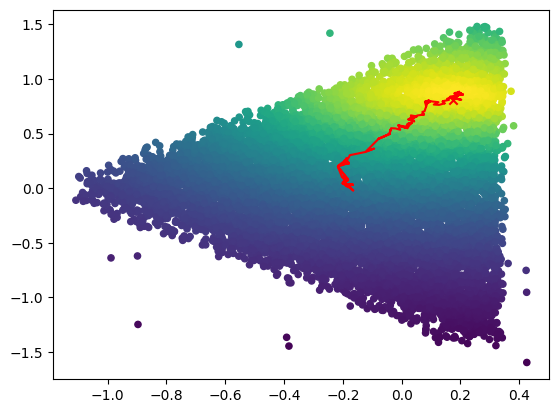

In [66]:
criterion = SBICriterion()
traj = []
max_values = []
for t in tqdm(range(1000, 0, -1)):
    likelihood = (
        guidance_model.forward(
            thetas[[idx]],
            x_o[None],
            guidance_model.get_diff_time_repr(np.ones(1) * t),
        )
        .detach()
        .numpy()
    )
    likelihood = likelihood[0, :, 0]
    likelihood = np.exp(-likelihood)
    max_idx = np.argmax(likelihood)
    max_values.append(likelihood[max_idx])
    traj.append(x_o[max_idx])


plt.scatter(*x_o.detach().numpy().T, c=likelihood, s=20)

traj = torch.stack(traj)
traj = traj.detach().numpy()

plt.plot(*traj.T, color="r")
plt.scatter(*x_o[idx].detach().numpy(), color="r", marker="x")

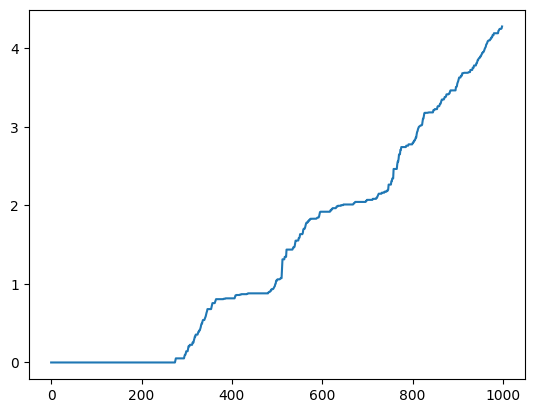

In [74]:
# plt.plot(max_values[::-1])
plt.plot(np.linalg.norm(np.diff(traj, axis=0), axis=1).cumsum())

Text(0.5, 0.98, 'Likelihood estimate vs gt: idx=0')

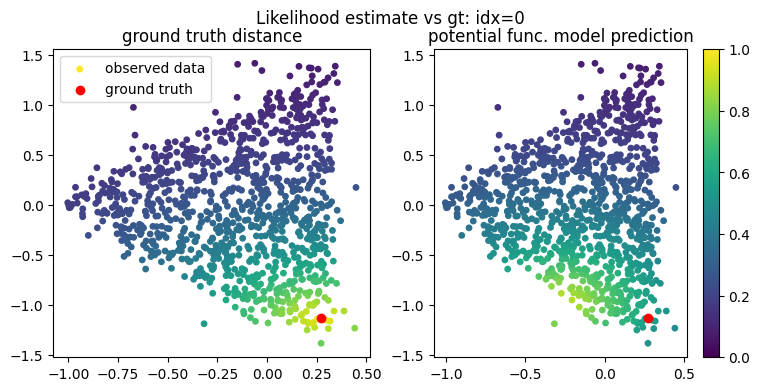

In [97]:
ckpt = project_root.joinpath("results", "gbi", "two_moons", "lightning_logs", "version_71", "epoch=94-step=3800.ckpt")
potential_function = PotentialNetwork.load_from_checkpoint(ckpt)
likelihood = potential_function.forward(x_o[[idx]], x_o[None]).detach().numpy()
likelihood = np.exp(-likelihood[0, :, 0])
criterion = SBICriterion()
ground_truth_distance = criterion.sample_distance(x_o[[idx]], x_o[None])
gt_likelihood = np.exp(-ground_truth_distance[0])

fig, axs = plt.subplots(ncols=2, figsize=(9, 4))

mapable = axs[0].scatter(*x_o.detach().numpy().T, c=gt_likelihood, s=15, label="observed data", vmin=0, vmax=1)
axs[0].scatter(*x_o[idx], c="r", label="ground truth")
axs[0].set_title("ground truth distance")
axs[0].legend()

mapable = axs[1].scatter(*x_o.detach().numpy().T, c=likelihood, s=15, label="observed data",  vmin=0, vmax=1)
axs[1].scatter(*x_o[idx], c="r", label="ground truth")
axs[1].set_title("potential func. model prediction")


fig.colorbar(mapable)
fig.suptitle(f"Likelihood estimate vs gt: idx={idx}")

1000it [00:01, 545.51it/s]


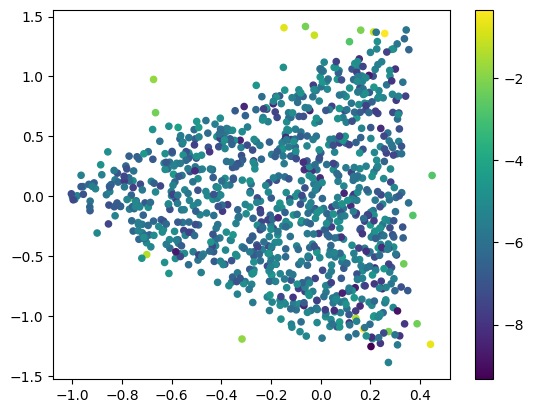

In [98]:
criterion = SBICriterion()
mean_dist = []
for x, theta in tqdm(zip(x_o, thetas)):
    likelihood = potential_function.forward(theta[None], x_o[None]).detach().numpy()
    likelihood = likelihood[0, :, 0]
    # likelihood = np.exp(-likelihood[0, :, 0])
    gt_distance = criterion.sample_distance(x[None], x_o[None]).detach().numpy()
    gt_distance = gt_distance[0]
    # gt_likelihood = np.exp(-ground_truth_distance[0])
    # print(likelihood.shape, ground_truth_distance.shape)
    # plt.scatter(*x, c="r", label="ground truth")
    # plt.scatter(*x_o.detach().numpy().T, c=gt_distance, s=15, label="observed data", vmin=0, vmax=1)
    mean_dist.append(np.mean(np.square(likelihood - gt_distance)).item())

plt.scatter(*x_o.detach().numpy().T, c=np.log(mean_dist), s=20)
plt.colorbar()

# sampling from the SBI posterior

Step in diffusion process: 100%|██████████| 1000/1000 [00:12<00:00, 77.15it/s]


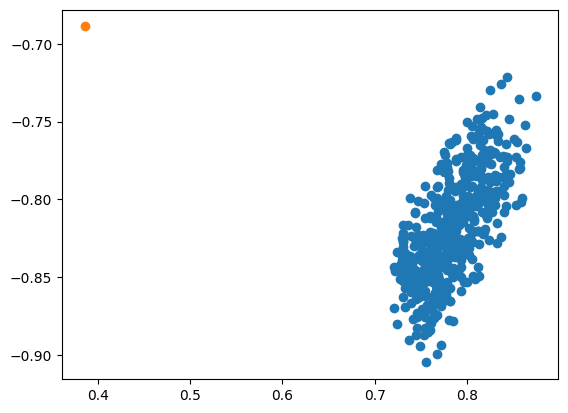

In [100]:
diff_ckpt = str(project_root) + "/results/diffusion/two_moons/lightning_logs/version_0/epoch=94-step=3800.ckpt"
config = Config.from_file(str(project_root) + "/config/sampling_diffusion.yaml")
config.observed_data_file = str(project_root.joinpath("data","two_moons_1000.pt"))
sampler = DiffusionSampler(diff_ckpt, guidance_ckpt, config)
sampler.update_beta(1000)
samples = sampler.single_forward(x_o[idx], 512)
plt.scatter(*samples.T.detach().numpy())
plt.scatter(*thetas[idx])